In [7]:
import sys, pathlib
ROOT = pathlib.Path.cwd().resolve()
while ROOT.name != "Implementation_human_mouse" and ROOT != ROOT.parent:
    ROOT = ROOT.parent
if ROOT.name != "Implementation_human_mouse":
    raise RuntimeError("Could not find repo root 'Implementation_human_mouse'")

sys.path.insert(0, str(ROOT))  

import os, pickle, random
import numpy as np
import torch
from torch.utils.data import DataLoader
from copy import deepcopy

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from src.pytorch_models import LightningRNNModule
from src.dataset        import RuleBasedTasks, collate_fn


In [8]:
# load model & config
run_folder = "skilled-surf-178_fdgo_s1_fdgo_v1_reactgo_s1_reactgo_v1_delaygo_s1_delaygo_v1_fdanti_s1_fdanti_v1_reactanti_s1_reactanti_v1_delayanti_s1_delayanti_v1_dmsgo_dmsnogo_dmcgo_dmcnogo_V1_5_FEF_5_3b_5"
checkpoint_dir = ROOT / "saved_models" / "cernn" / run_folder     # human

print("Checkpoint dir →", checkpoint_dir)
if not checkpoint_dir.exists():
    raise FileNotFoundError(checkpoint_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

ckpt_files = sorted(f for f in os.listdir(checkpoint_dir) if f.endswith(".ckpt"))
if not ckpt_files:
    raise FileNotFoundError("No .ckpt files in " + str(checkpoint_dir))
ckpt_path = os.path.join(checkpoint_dir, ckpt_files[0])
print("▶ Loading checkpoint:", ckpt_path)

with open(os.path.join(checkpoint_dir, "hp_pl_module.pkl"), "rb") as f:
    hp_pl_module = pickle.load(f)
with open(os.path.join(checkpoint_dir, "task_hp.pkl"), "rb") as f:
    task_hp = pickle.load(f)

model = LightningRNNModule.load_from_checkpoint(ckpt_path, strict=False).to(device)  
model.eval().freeze()

def _get_hparam(*keys, default=None):
    cur = hp_pl_module
    for k in keys:
        if not hasattr(cur, k):
            cur = None; break
        cur = getattr(cur, k)
    if cur is not None: return cur
    if hasattr(model, "hparams"):
        h = dict(model.hparams)
        dotted = ".".join(keys)
        if dotted in h:   return h[dotted]
        if keys[-1] in h: return h[keys[-1]]
    return default

UNITS          = int(_get_hparam("embedding", "n_units", default=192))
SEED_EMBEDDING = int(_get_hparam("embedding", "seed",    default=0))
SPECIES        =      _get_hparam("species", default=getattr(hp_pl_module, "species", "human"))  
GLOBAL_SEED    =      _get_hparam("seed", default=42)
SEED = SEED_EMBEDDING if GLOBAL_SEED is None else int(GLOBAL_SEED)
print(f"global SEED: {GLOBAL_SEED}")
print(f"Embedding seed: {SEED_EMBEDDING}")

np.random.seed(SEED); torch.manual_seed(SEED); random.seed(SEED)
torch_gen = torch.Generator().manual_seed(SEED)

from src import task as _task_mod  
ckpt_rules = list(task_hp["rule_trains"])       
print("\n[INFO] Rules from checkpoint:", ckpt_rules)  
# Override the global table used by get_rule_index():
_task_mod.rules_dict["all"] = ckpt_rules        


try:
    _orig_get_rule_index = _task_mod.get_rule_index                              
except AttributeError:
    _orig_get_rule_index = None                                                  

def _get_rule_index_ckpt(rule, config=None):                                     
    base = int(task_hp_det.get("rule_start", 1 + num_ring * n_eachring))         
    # Prefer the checkpoint’s rules (what the model was trained with)
    if rule in ckpt_rules:                                                       
        return base + ckpt_rules.index(rule)                                     
    # Fallback to original behavior if needed (other scripts might call this)
    if _orig_get_rule_index is not None:                                         
        return _orig_get_rule_index(rule, config)                                
    raise KeyError(f"Unknown rule: {rule}")                                      

_task_mod.get_rule_index = _get_rule_index_ckpt                                  



num_ring       = task_hp.get("num_ring", task_hp.get("num_ring", 1))
n_eachring     = task_hp.get("n_eachring", task_hp.get("n_eachring", 2))
task_hp["n_rule"]     = len(ckpt_rules)        
task_hp["rule_trains"] = ckpt_rules           
task_hp["rules"]       = ckpt_rules           
task_hp["rule_start"]  = 1 + num_ring * n_eachring  
task_hp["n_input"]     = 1 + num_ring * n_eachring + task_hp["n_rule"]  

# Make a deterministic copy of hp
from copy import deepcopy
task_hp_det        = deepcopy(task_hp)
import numpy as np
task_hp_det["rng"] = np.random.RandomState(SEED)   


Checkpoint dir → /Users/hsuyatikhin/Downloads/UoB/UoB Data Science (MSc)/8. Data Science Project 2024/###Final Dissertation/Implementation_human_mouse/saved_models/cernn/skilled-surf-178_fdgo_s1_fdgo_v1_reactgo_s1_reactgo_v1_delaygo_s1_delaygo_v1_fdanti_s1_fdanti_v1_reactanti_s1_reactanti_v1_delayanti_s1_delayanti_v1_dmsgo_dmsnogo_dmcgo_dmcnogo_V1_5_FEF_5_3b_5
Using device: cpu
▶ Loading checkpoint: /Users/hsuyatikhin/Downloads/UoB/UoB Data Science (MSc)/8. Data Science Project 2024/###Final Dissertation/Implementation_human_mouse/saved_models/cernn/skilled-surf-178_fdgo_s1_fdgo_v1_reactgo_s1_reactgo_v1_delaygo_s1_delaygo_v1_fdanti_s1_fdanti_v1_reactanti_s1_reactanti_v1_delayanti_s1_delayanti_v1_dmsgo_dmsnogo_dmcgo_dmcnogo_V1_5_FEF_5_3b_5/epoch=161-val_perf=0.99.ckpt
['L_V1', 'L_3b'] ['L_FEF']
{0: 5, 9: 5, 8: 5}
visual start 0 visual end 5
somatosensory start 12 somatosensory end 17
global SEED: 42
Embedding seed: 0

[INFO] Rules from checkpoint: ['fdgo_s1', 'fdgo_v1', 'reactgo_s1', 'r

In [9]:
# one trial, baseline from fixation, keep fixation (baseline-subtracted), with diagnostics (PATCHED)

RULE_FOR_PCA = "delaygo_s1"  
print(f"[INFO] Using rule for PCA: {RULE_FOR_PCA}")  

# Use mode="test" to iterate rules deterministically, one batch per rule
dl = DataLoader(
    RuleBasedTasks(task_hp_det, mode="test"), batch_size=1,
    collate_fn=collate_fn, shuffle=False, generator=torch_gen
)

# Scan for the requested rule
batch = None
for b in dl:
    if getattr(b, "rule", None) == RULE_FOR_PCA:
        batch = b
        break
if batch is None:
    # If not yielded by mode='test' (shouldn’t happen), fall back to mode='train'
    print("[WARN] Rule not found in test iterator; falling back to train iterator")
    dl_train = DataLoader(
        RuleBasedTasks(task_hp_det, mode="train"), batch_size=1,
        collate_fn=collate_fn, shuffle=True, generator=torch_gen
    )
    for b in dl_train:
        if getattr(b, "rule", None) == RULE_FOR_PCA:
            batch = b
            break
if batch is None:
    raise RuntimeError(f"Could not find/generate a batch for rule {RULE_FOR_PCA}")

batch.x, batch.c_mask = batch.x.to(device), batch.c_mask.to(device)
with torch.no_grad():
    _, h = model.eval_step(batch)

H = h[:, 0, :].cpu().numpy()          # (T, UNITS)
T = H.shape[0]
print(f"Timesteps (T): {T}, UNITS: {UNITS}")

# Fixation window
s_fix_raw, e_fix_raw = batch.epochs.get("fix1", (None, None))
s_fix = 0 if s_fix_raw is None else int(s_fix_raw)
e_fix = T if e_fix_raw is None else int(e_fix_raw)
s_fix = max(0, min(s_fix, T)); e_fix = max(0, min(e_fix, T))

# Baseline = mean over fixation, per unit
baseline = H[s_fix:e_fix].mean(axis=0)            # (UNITS,)
H_bs = H - baseline                               # (T, UNITS)  

# Build epoch segments on full timebase
SEGMENTS_FULL = []
for name, (s, e) in batch.epochs.items():
    s0 = 0 if s is None else int(s)
    e0 = T if e is None else int(e)
    # s0 = max(0, min(s0, T)); e0 = max(0, min(e0, T))
    if e0 > s0:
        SEGMENTS_FULL.append((name, s0, e0))
SEGMENTS_FULL.sort(key=lambda x: x[1])

# Onset indices for vertical lines
ONSETS = [(name, s0) for name, s0, e0 in SEGMENTS_FULL]  
print("Onsets:", ONSETS)  

[INFO] Using rule for PCA: delaygo_s1
Timesteps (T): 125, UNITS: 192
Onsets: [('fix1', 0), ('stim1', 25), ('delay1', 50), ('go1', 100)]


In [10]:
from pathlib import Path
import itertools

unit_labels = None
# Prefer labels from the model (works for both human & mouse)
if hasattr(model, "ce") and hasattr(model.ce, "area_labels"):
    unit_labels = list(model.ce.area_labels)

# Fallback: species-aware disk path
if unit_labels is None or len(unit_labels) != UNITS:
    lbl_path = (ROOT / "src" / "data" / "human_areaNamesGlasser180.txt")
    if not lbl_path.exists():
        raise FileNotFoundError(f"Could not find label_names.txt at {lbl_path}")
    with open(lbl_path, "r") as f:
        unit_labels = [ln.strip() for ln in f.readlines()]

    # 🔧 Expand labels if fewer than UNITS
    if len(unit_labels) < UNITS:
        unit_labels = list(itertools.islice(itertools.cycle(unit_labels), UNITS))

assert len(unit_labels) == UNITS, (len(unit_labels), UNITS)
print(f"[labels] species={SPECIES}  units={UNITS}  (first 10):", unit_labels[:10])


[labels] species=human  units=192  (first 10): ['L_V1', 'L_MST', 'L_V6', 'L_V2', 'L_V3', 'L_V4', 'L_V8', 'L_4', 'L_3b', 'L_FEF']


In [11]:
# species-agnostic parcel/network utilities 
import pandas as pd, re, numpy as np

# if str(SPECIES).lower().startswith("mac"):                                        
#     CSV_PATH = ROOT / "src" / "data" / "lyon_regions_cog_networks_overlap.csv"    
# else:                                                                              
CSV_PATH = ROOT / "src" / "data" / "hcp_regions_cog_networks_overlap.csv"     
df_overlap = pd.read_csv(CSV_PATH)                                                 
print(f"[net csv] {CSV_PATH.name}  rows={len(df_overlap)}  cols={list(df_overlap.columns)}")  

# Infer network columns: numeric columns except the id column
id_candidates = ["Row","row","Parcel","parcel","Region","region"]                 
id_col = next((c for c in id_candidates if c in df_overlap.columns), df_overlap.columns[0])  
num_cols = [c for c in df_overlap.columns if c != id_col and np.issubdtype(df_overlap[c].dtype, np.number)]  
if not num_cols: raise RuntimeError("No numeric network columns found in CSV.")   
NETWORK_COLUMNS = num_cols                                                         
print("[networks]", NETWORK_COLUMNS)                                               

# drop tags, strip suffixes
_hemi_pat = re.compile(r'^(L[_\-\.]?)+', re.I)     
_suf_pat  = re.compile(r'(_ROI|\.label|\.txt)$', re.I)                              
def _canon(s: str) -> str:                                                          
    s = str(s).strip()
    s = _hemi_pat.sub("", s)
    s = _suf_pat.sub("", s)
    s = s.replace(" ", "").replace("-", "").replace(".", "")
    return s

tmp = {}
for _, r in df_overlap.iterrows():                                                  
    base = _canon(r[id_col])                                                        
    vec  = r[NETWORK_COLUMNS].to_numpy(dtype=float)
    tmp.setdefault(base, []).append(vec)
parcel2net = {k: np.vstack(v).mean(axis=0) for k, v in tmp.items()}                

print("Example parcel2net entries:", list(parcel2net.items())[:5])                  

def parcel_to_network_weights(parcel: str) -> np.ndarray:
    return parcel2net.get(_canon(parcel), None)                                     

def parcel_to_dominant_network(parcel: str, min_prop: float = 0.5):
    w = parcel_to_network_weights(parcel)
    if w is None: return None, 0.0
    k = int(np.argmax(w)); prop = float(w[k]); name = NETWORK_COLUMNS[k]
    if prop >= min_prop: return name, prop
    return None, prop


[net csv] hcp_regions_cog_networks_overlap.csv  rows=180  cols=['Row', 'DorsAtt', 'FPN', 'Default', 'Visual', 'Limbic', 'SomMot', 'Salience']
[networks] ['DorsAtt', 'FPN', 'Default', 'Visual', 'Limbic', 'SomMot', 'Salience']
Example parcel2net entries: [('V1', array([0., 0., 0., 1., 0., 0., 0.])), ('MST', array([0.69863014, 0.        , 0.        , 0.30136986, 0.        ,
       0.        , 0.        ])), ('V6', array([0., 0., 0., 1., 0., 0., 0.])), ('V2', array([0., 0., 0., 1., 0., 0., 0.])), ('V3', array([0., 0., 0., 1., 0., 0., 0.]))]


In [12]:
# build masks for ALL networks 
from collections import Counter

MIN_PROP  = 0.5

# Compute dominant networks with threshold
unit_dom_net = [(parcel_to_dominant_network(lbl, min_prop=MIN_PROP)) for lbl in unit_labels]  
matched = sum(parcel_to_network_weights(lbl) is not None for lbl in unit_labels)               
print(f"[coverage] matched parcels: {matched}/{UNITS} ({matched/UNITS:.1%})")                  

# Auto-relax if too many unassigned OR too many unmatched
frac_unassigned = sum(n is None for n,_ in unit_dom_net) / len(unit_dom_net)                   
if frac_unassigned > 0.40 or matched/UNITS < 0.85:                                             
    print(f"[warn] Unassigned={frac_unassigned:.0%} (or coverage low). "
          f"Relaxing threshold to 0.4 and assigning by argmax when needed.")                   
    MIN_PROP = 0.4                                                                              
    unit_dom_net = []
    for lbl in unit_labels:                                                                     
        w = parcel_to_network_weights(lbl)
        if w is None:                                                                           
            unit_dom_net.append((None, 0.0))
        else:
            k = int(np.argmax(w)); prop = float(w[k]); name = NETWORK_COLUMNS[k]
            unit_dom_net.append((name if prop >= MIN_PROP else name, prop))                    

# Build masks (NETWORK_COLUMNS order preserved)
net_masks = {net: np.array([n == net for (n, _) in unit_dom_net], dtype=bool)
             for net in NETWORK_COLUMNS}
net_masks["Unassigned"] = np.array([n is None for (n, _) in unit_dom_net], dtype=bool)

# Counts
counts = Counter(n if n is not None else "Unassigned" for (n, _) in unit_dom_net)
print("Dominant-network counts (MIN_PROP =", MIN_PROP, "):")
for k in NETWORK_COLUMNS + ["Unassigned"]:
    print(f"  {k:>10s}: {counts.get(k, 0)}")


[coverage] matched parcels: 192/192 (100.0%)
Dominant-network counts (MIN_PROP = 0.5 ):
     DorsAtt: 25
         FPN: 27
     Default: 34
      Visual: 33
      Limbic: 12
      SomMot: 29
    Salience: 22
  Unassigned: 10


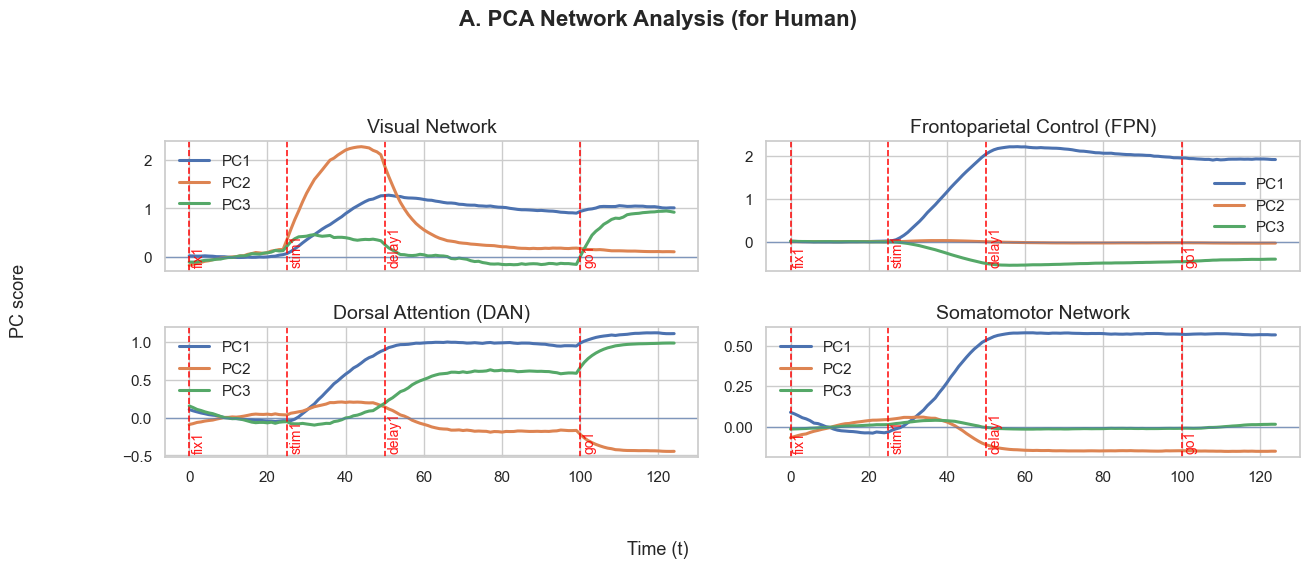

In [13]:
# 4 panels

import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Any
from pathlib import Path                                                             

# ===== helpers to normalize epoch specs =====
def _segments_to_items(segments: Any) -> List[Tuple[str, Tuple[int,int]]]:
    if isinstance(segments, dict):
        items = [(k, tuple(v)) for k, v in segments.items()]
    else:
        items = []
        for i, el in enumerate(segments):
            if isinstance(el, (list, tuple)):
                if len(el) == 2 and isinstance(el[0], str):
                    name, (st, en) = el[0], el[1]; items.append((name, (int(st), int(en))))
                elif len(el) == 3 and isinstance(el[0], str):
                    name, st, en = el; items.append((name, (int(st), int(en))))
                elif len(el) == 2 and all(isinstance(x, (int, np.integer)) for x in el):
                    items.append((f"epoch_{i+1}", (int(el[0]), int(el[1]))))
                else:
                    raise ValueError(f"Bad epoch spec at {i}: {el}")
            else:
                raise ValueError(f"Epoch entry {i} must be tuple/list.")
    return sorted(items, key=lambda kv: kv[1][0])

SEG_ITEMS = _segments_to_items(SEGMENTS_FULL)                                       

# ===== 1) Baseline subtraction only =====
mu_fix = H[s_fix:e_fix, :].mean(axis=0, keepdims=True)                              
X_full = H - mu_fix                                                                     # no further scaling

# ===== 2) PCA via SVD on baseline-subtracted data (all timepoints) =====
U, S, Vt   = np.linalg.svd(X_full, full_matrices=False)                              
k          = min(10, Vt.shape[0])                                                    
components = Vt[:k, :]                                                               
Z_all      = X_full @ components.T                                                   
expl_var   = (S[:k]**2) / np.sum(S**2)                                               
cum_expl   = np.cumsum(expl_var)                                                     

def _epoch_boundaries_and_labels(items):                                             
    onsets=[st for _,(st,_) in items]; names=[nm for nm,_ in items]; return onsets, names  

# ===== 3) Project a mask into the same PC space =====
def project_network_in_all_pc_space(mask_bool: np.ndarray) -> np.ndarray:            
    Xm = X_full.copy(); Xm[:, ~mask_bool] = 0.0                                      
    return Xm @ components.T                                                         

# ===== 4) Four-panel plot (Visual / FPN / Dorsal Attention / Somatomotor) =====
PANEL_NETS = ["Visual", "FPN", "DorsAtt", "SomMot"]                                  
DISPLAY_NAME = {                                                                     
    "Visual":   "Visual Network",                                                    
    "FPN":      "Frontoparietal Control (FPN)",                                      
    "DorsAtt":  "Dorsal Attention (DAN)",                                            
    "DosrAtt":  "Dorsal Attention (DAN)",   # handle common typo                     
    "SomMot":   "Somatomotor Network",                                               
}                                                                                    

LINEWIDTH       = 2.2                                                                
LEGEND_FONTSIZE = 11                                                                 
TITLE_FONTSIZE  = 14                                                                 
AXIS_FONTSIZE   = 13                                                                 
TICK_FONTSIZE   = 11                                                                 
EPOCH_FONT      = 10                                                                 
EPOCH_ALPHA     = 0.9                                                                
EPOCH_PAD_FRAC  = 0.03                                                               
PCS_TO_PLOT     = (0, 1, 2)                                                          
DRAW_ZERO_LINE  = True                                                               
UNIFY_YLIMS     = False                                                              

# Output path (auto-creates folder)
out_dir  = ROOT / "notebooks" / "figures"                                           
out_dir.mkdir(parents=True, exist_ok=True)                                          
OUT_PATH = out_dir / "pc_timecourses_4panels.pdf"                                   

# Resolve panels that exist; fall back to top-4 by count
available = [n for n in PANEL_NETS if n in net_masks and net_masks[n].sum() >= 2]   
if len(available) < 4:                                                               
    counts = {k: int(mask.sum()) for k, mask in net_masks.items() if k != "Unassigned"}  
    available = [k for k,_ in sorted(counts.items(), key=lambda kv: -kv[1])[:4]]     

fig, axes = plt.subplots(2, 2, figsize=(13.5, 5.6), sharex=True)                     
axes = axes.ravel()                                                                  
onsets, names = _epoch_boundaries_and_labels(SEG_ITEMS)                              

for ax, net_key in zip(axes, available):                                             
    mask = net_masks[net_key]                                                        
    Z_net = project_network_in_all_pc_space(mask)                                    

    for p in PCS_TO_PLOT:                                                            
        if p < Z_net.shape[1]:
            ax.plot(Z_net[:, p], label=f"PC{p+1}", lw=LINEWIDTH)                     

    if DRAW_ZERO_LINE:                                                               
        ax.axhline(0, lw=1.0, alpha=0.6)                                               

    # vertical onsets + names at bottom
    for x in onsets:                                                                 
        ax.axvline(x, color="red", linestyle="--", linewidth=1.2, alpha=EPOCH_ALPHA) 
    y0, y1 = ax.get_ylim()                                                           
    y_text = y0 + EPOCH_PAD_FRAC * (y1 - y0)                                         
    for x, nm in zip(onsets, names):                                                 
        ax.text(x + 0.6, y_text, nm, color="red", fontsize=EPOCH_FONT, rotation=90,  
                va="bottom", ha="left", alpha=EPOCH_ALPHA)                           

    title = DISPLAY_NAME.get(net_key, net_key)                    
    ax.set_title(title, fontsize=TITLE_FONTSIZE)                                     
    ax.tick_params(labelsize=TICK_FONTSIZE)                                          
    ax.legend(frameon=False, fontsize=LEGEND_FONTSIZE)                               

# Shared labels
fig.supxlabel("Time (t)", fontsize=AXIS_FONTSIZE, y=0.04)                                    
fig.supylabel("PC score", fontsize=AXIS_FONTSIZE, x=0.02)  
# ===== Add overall figure title =====
fig.suptitle("A. PCA Network Analysis (for Human)", fontsize=16, fontweight="bold", y=1.02)


if UNIFY_YLIMS:                                                                      
    ylims = np.array([ax.get_ylim() for ax in axes]); ymin, ymax = ylims[:,0].min(), ylims[:,1].max()  
    for ax in axes: 
        # ax.set_ylim(ymin, ymax)                                          
        ax.set_xlabel("Time (t)", fontsize=AXIS_FONTSIZE, labelpad=4)    
        ax.set_ylabel("PC score", fontsize=AXIS_FONTSIZE, labelpad=4)   
        


fig.tight_layout(pad=2.0, rect=(0.04, 0.02, 1, 0.98))                                
# fig.savefig(OUT_PATH, bbox_inches="tight", dpi=300)                                   
# print(f"[saved] {OUT_PATH}")                                                         
plt.show()                                                                           


network sizes: {'DorsAtt': 25, 'FPN': 27, 'Default': 34, 'Visual': 33, 'Limbic': 12, 'SomMot': 29, 'Salience': 22}


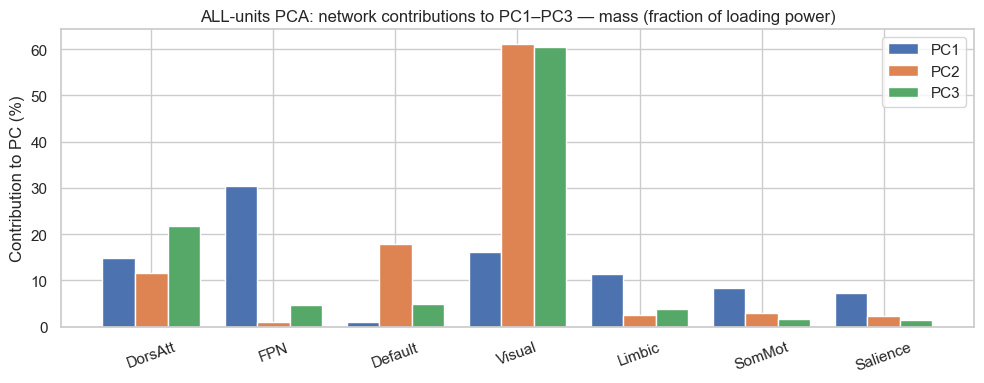

In [14]:
# PC weights by network (global PC space), with normalization
import numpy as np, matplotlib.pyplot as plt  

UNITS = components.shape[1]                                                     
K      = components.shape[0]                                                    
L      = components.T                                                             # (UNITS, K)

if "NETWORK_COLUMNS" in globals():                                              
    nets_order = [n for n in NETWORK_COLUMNS if n in net_masks]                 
else:                                                                           
    nets_order = sorted(net_masks.keys())                                       

if "unit_labels" in globals() and len(unit_labels) == UNITS:                    
    labels = np.asarray(unit_labels)                                            
else:                                                                           
    labels = np.array([f"u{j:03d}" for j in range(UNITS)])                      

#--- choose normalization mode ---
NORM_MODE = "mass"              # options: "mass" (default) | "by_count"
#  mass:   sum(L^2) within network / sum(L^2) over all units (current behavior)
#  by_count: mean(L^2) within network, then renormalize across networks to sum to 1 (size-normalized)

def network_contributions_from_L(L, net_masks, nets_order, k_top=3, norm="mass"):  
    Kuse = min(k_top, L.shape[1])                                               
    C = np.zeros((len(nets_order), Kuse), dtype=float)                          
    sizes = np.array([max(1, net_masks[n].sum()) for n in nets_order], float)   
    for k in range(Kuse):                                                       
        w2 = L[:, k]**2                                                         
        if norm == "mass":                                                      
            denom = w2.sum() + 1e-12                                            
            for i, n in enumerate(nets_order):                                  
                m = net_masks[n]                                                
                C[i, k] = w2[m].sum() / denom                                   
        elif norm == "by_count":                                                
            means = np.array([w2[net_masks[n]].mean() if sizes[i] > 0 else 0.0  
                               for i, n in enumerate(nets_order)])              
            denom = means.sum() + 1e-12                                         
            C[:, k] = means / denom                                             
        else:                                                                    
            raise ValueError("norm must be 'mass' or 'by_count'")               
    return C, sizes                                                              

def plot_contrib_bars(nets, C, title):                                          
    Kuse = C.shape[1]; x = np.arange(len(nets)); w = 0.8 / Kuse                 
    plt.figure(figsize=(10, 4))                                                 
    for k in range(Kuse):                                                       
        plt.bar(x + (k - (Kuse-1)/2)*w, 100*C[:, k], width=w, label=f"PC{k+1}") 
    plt.xticks(x, nets, rotation=20); plt.ylabel("Contribution to PC (%)")      
    plt.title(title); plt.legend(); plt.tight_layout(); plt.show()               

def print_top_units_per_pc(L, labels, net_masks, k_top=3, n_units=8):           
    Kuse = min(k_top, L.shape[1])                                               
    idx2net = np.array(["Unassigned"] * L.shape[0], dtype=object)               
    for n, m in net_masks.items(): idx2net[m] = n                                
    for k in range(Kuse):                                                       
        w = L[:, k]; order = np.argsort(-np.abs(w))[:n_units]                    
        print(f"\n=== Top {n_units} units for PC{k+1} (by |loading|) ===")       
        for j in order:                                                          
            print(f"{labels[j]:>12s} | {idx2net[j]:>10s} | loading={w[j]:+ .4f}")

C, sizes = network_contributions_from_L(L, net_masks, nets_order, k_top=3, norm=NORM_MODE)  
print("network sizes:", dict(zip(nets_order, map(int, sizes))))        
subtitle = "mass (fraction of loading power)" if NORM_MODE=="mass" else "size-normalized (mean loading power per unit)"  
plot_contrib_bars(nets_order, C, f"ALL-units PCA: network contributions to PC1–PC3 — {subtitle}")  
# print_top_units_per_pc(L, labels, net_masks, k_top=3, n_units=10)               


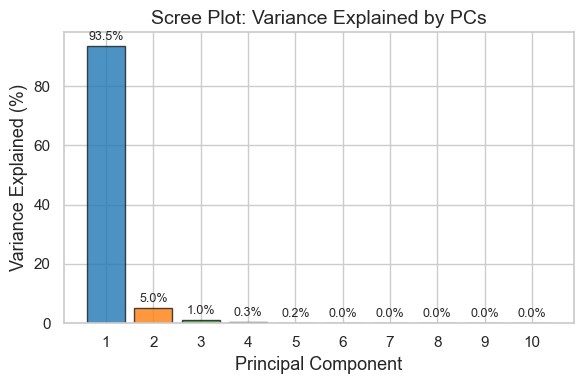

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid")
color_palette = sns.color_palette("tab10")  # 10 distinct colors

# Convert to percentages
expl_var_pct = expl_var * 100  
n_pcs_to_keep = k  # first 10 PCs

plt.figure(figsize=(6,4))
pcs = np.arange(1, n_pcs_to_keep+1)

# Assign a color to each bar
colors = color_palette[:n_pcs_to_keep]
plt.bar(pcs, expl_var_pct, color=colors, edgecolor='k', alpha=0.8)

plt.xlabel("Principal Component", fontsize=13)
plt.ylabel("Variance Explained (%)", fontsize=13)
plt.title("Scree Plot: Variance Explained by PCs", fontsize=14)
plt.xticks(pcs)

# Add % text on top of each bar
for i, v in enumerate(expl_var_pct):
    plt.text(pcs[i], v + 1, f"{v:.1f}%", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()